This notebook presents a simple credit risk model, aiming to predict if an individual is more likely to default on their loan

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.cluster import KMeans
import hdbscan
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import *
from pycaret.classification import *
from pycaret.classification import setup
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In this section, we will load and explore the credit risk dataset. We will start by reading the dataset from a CSV file, then we will check the shape of the dataset, its columns, and the data types of each column.

In [2]:
df_credit_risk_data =  pd.read_csv('/home/sihle/Kig_dataset/archive (1)/credit_risk_dataset.csv')
print("Shape of the our credit risk data", df_credit_risk_data.shape)
print("-----------------------------------------------------------------------------")
print("Columns of the credit risk data",df_credit_risk_data.columns)
print("-----------------------------------------------------------------------------")
print('data type of our data', df_credit_risk_data.dtypes)

Shape of the our credit risk data (32581, 11)
-----------------------------------------------------------------------------
Columns of the credit risk data Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')
-----------------------------------------------------------------------------
data type of our data person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


Next, we will identify and separate the categorical and numerical columns in our credit risk dataset

In [3]:
Catagorical_cred_data = [i for i in df_credit_risk_data.select_dtypes(include='object').columns]
numerical_cred_data = [i for i in df_credit_risk_data.select_dtypes(include='number').columns]

print('categorical columns in application data', Catagorical_cred_data)
print('----------------------------------------------------------------------------------------')
print('numerical columns in application data', numerical_cred_data)

categorical columns in application data ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
----------------------------------------------------------------------------------------
numerical columns in application data ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']


 we will visualize the relationship between various features and the default status in our credit risk dataset. We will use count plots and box plots to explore these relationships.

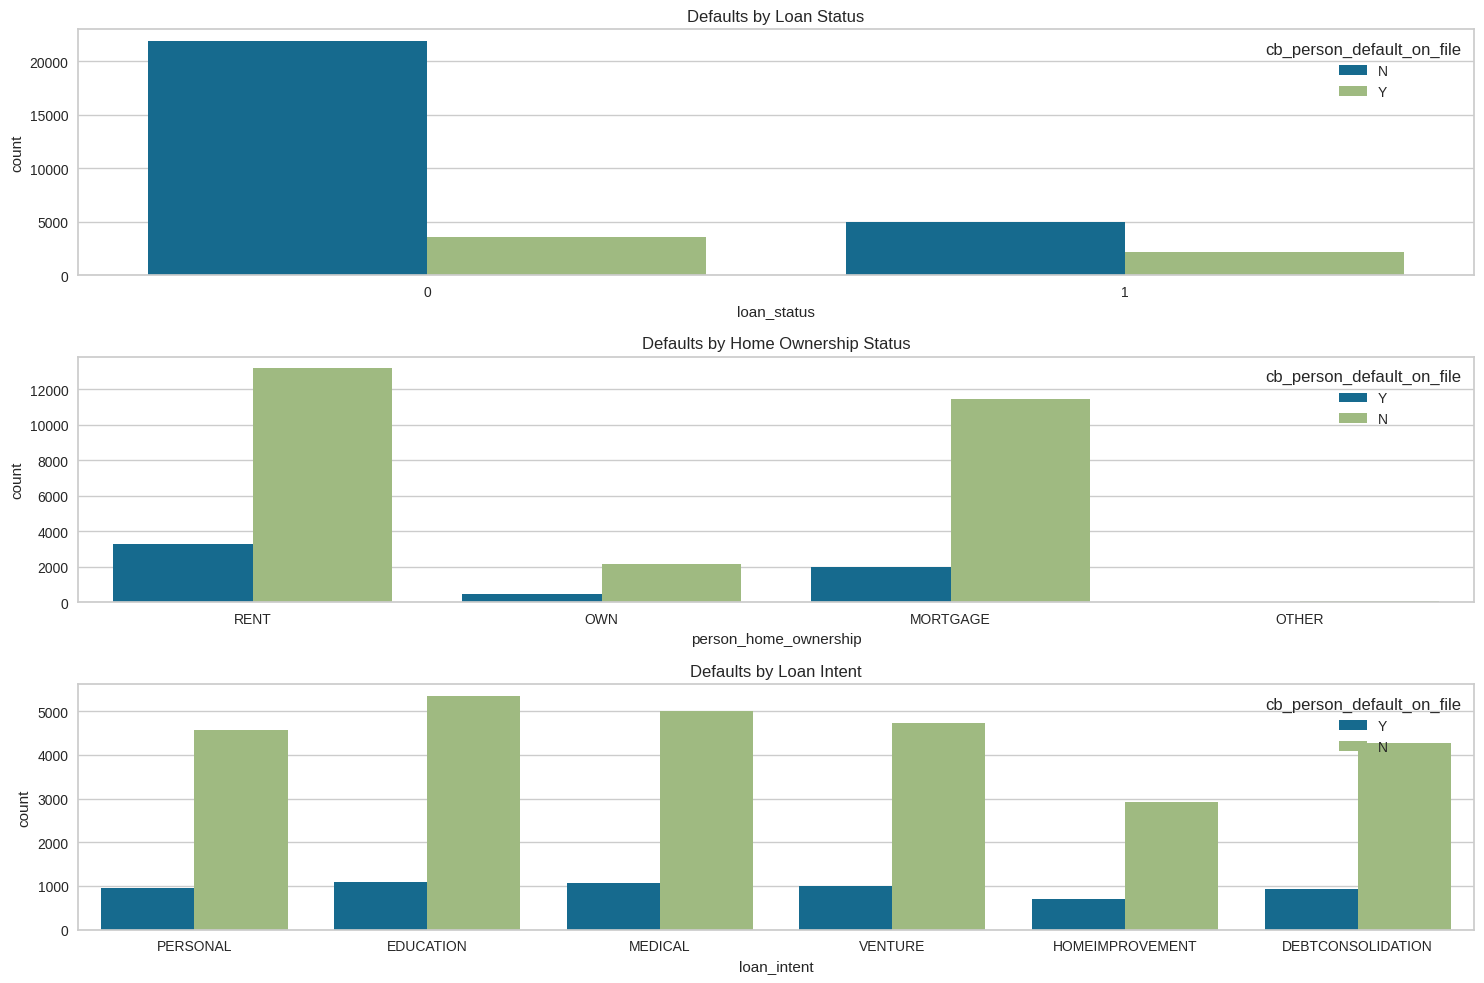

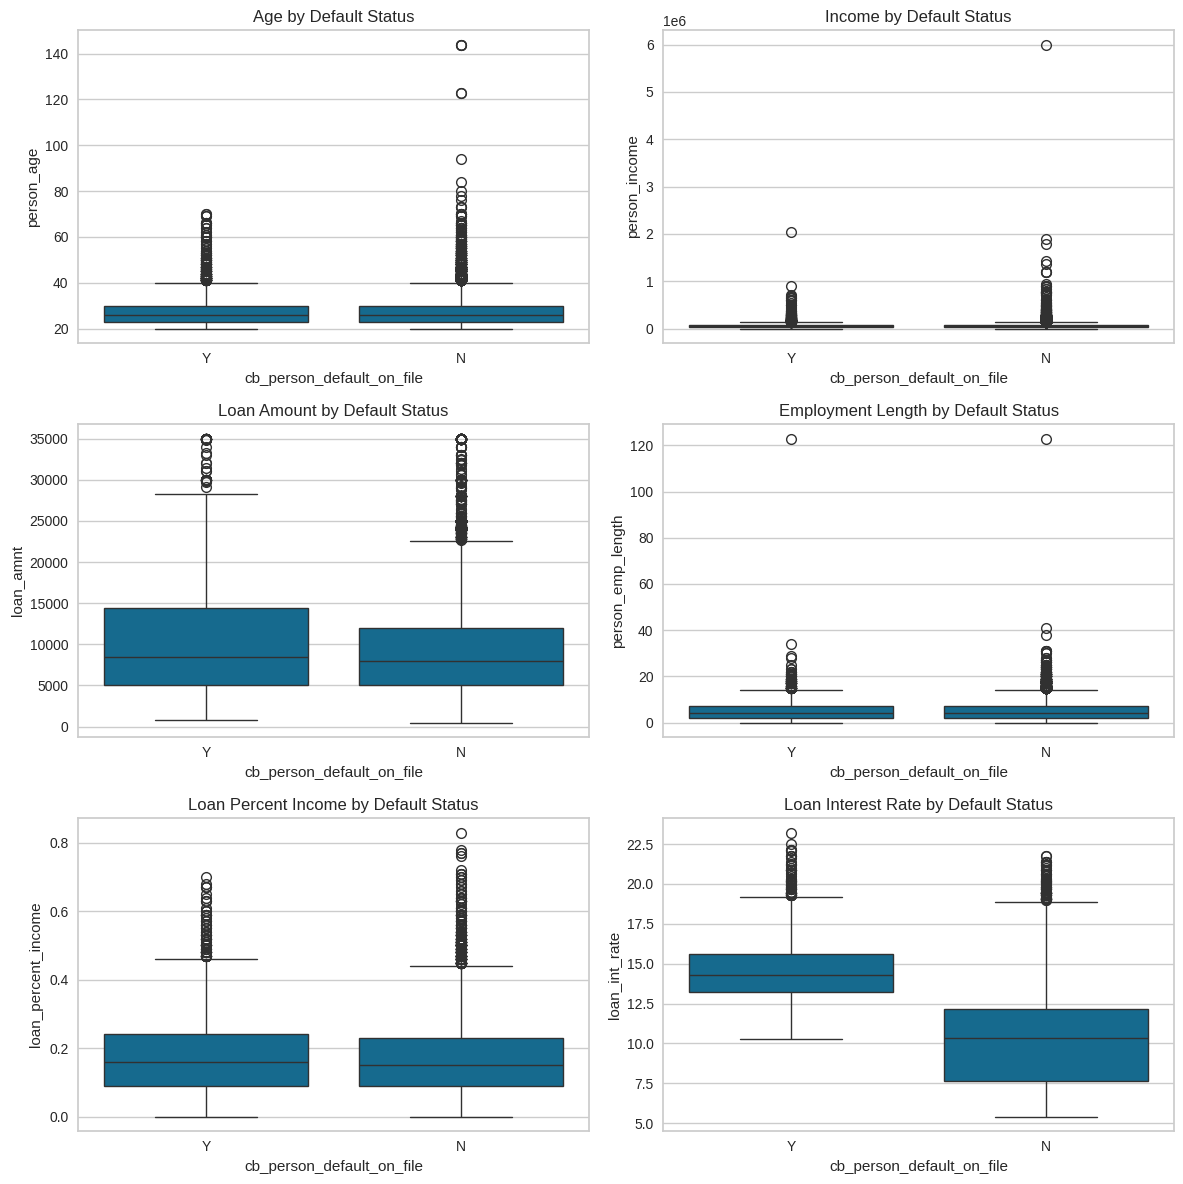

In [4]:
# Create count plots to visualize the relationship between categorical features and default status
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
df = df_credit_risk_data

sns.countplot(x=df["loan_status"], hue=df['cb_person_default_on_file'], ax=axes[0])
axes[0].set_title("Defaults by Loan Status")

sns.countplot(x=df["person_home_ownership"], hue=df['cb_person_default_on_file'], ax=axes[1])
axes[1].set_title("Defaults by Home Ownership Status")

sns.countplot(x=df["loan_intent"], hue=df['cb_person_default_on_file'], ax=axes[2])
axes[2].set_title("Defaults by Loan Intent")

plt.tight_layout()
plt.show()

# Create box plots to visualize the relationship between numerical features and default status
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

sns.boxplot(data=df, x="cb_person_default_on_file", y="person_age", ax=axes[0, 0])
axes[0, 0].set_title("Age by Default Status")
axes[0, 0].ticklabel_format(style='plain', axis='y')

sns.boxplot(data=df, x="cb_person_default_on_file", y="person_income", ax=axes[0, 1])
axes[0, 1].set_title("Income by Default Status")

sns.boxplot(data=df, x="cb_person_default_on_file", y="person_emp_length", ax=axes[1, 1])
axes[1, 1].set_title("Employment Length by Default Status")

sns.boxplot(data=df, x="cb_person_default_on_file", y="loan_amnt", ax=axes[1, 0])
axes[1, 0].set_title("Loan Amount by Default Status")

sns.boxplot(data=df, x="cb_person_default_on_file", y="loan_int_rate", ax=axes[2, 1])
axes[2, 1].set_title("Loan Interest Rate by Default Status")

sns.boxplot(data=df, x="cb_person_default_on_file", y="loan_percent_income", ax=axes[2, 0])
axes[2, 0].set_title("Loan Percent Income by Default Status")

plt.tight_layout()
plt.show()

In this section, we will handle outliers in the person_age and person_emp_length columns. Specifically, we will replace values that exceed reasonable thresholds with the mean value of the respective column.

In [5]:
# Calculate the mean values for the columns
mean_age = df.loc[df['person_age'] <= 100, 'person_age'].mean()
mean_emp_length = df.loc[df['person_emp_length'] <= 60, 'person_emp_length'].mean()

# Replace values greater than the thresholds with the mean values
df.loc[df['person_age'] > 100, 'person_age'] = mean_age
df.loc[df['person_emp_length'] > 60, 'person_emp_length'] = mean_emp_length

In [6]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22.0,59000,RENT,4.782224,PERSONAL,35000,16.02,1,0.59,Y,3
1,21.0,9600,OWN,5.000000,EDUCATION,1000,11.14,0,0.10,N,2
2,25.0,9600,MORTGAGE,1.000000,MEDICAL,5500,12.87,1,0.57,N,3
3,23.0,65500,RENT,4.000000,MEDICAL,35000,15.23,1,0.53,N,2
4,24.0,54400,RENT,8.000000,MEDICAL,35000,14.27,1,0.55,Y,4


Converting categorical variables into numerical format using the get_dummies function. Additionally, we will encode the binary categorical variable cb_person_default_on_file to numeric values.

In [7]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
df['person_home_ownership_encoded'] = label_encoder.fit_transform(df['person_home_ownership'])
df['loan_intent_encoded'] = label_encoder.fit_transform(df['loan_intent'])
df.drop(['person_home_ownership', 'loan_intent'], axis=1, inplace=True)
df['cb_person_default_on_file'] = [1 if i == "Y" else 0 for i in df['cb_person_default_on_file']]

In [8]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_encoded,loan_intent_encoded
0,22.0,59000,4.782224,35000,16.02,1,0.59,1,3,3,4
1,21.0,9600,5.000000,1000,11.14,0,0.10,0,2,2,1
2,25.0,9600,1.000000,5500,12.87,1,0.57,0,3,0,3
3,23.0,65500,4.000000,35000,15.23,1,0.53,0,2,3,3
4,24.0,54400,8.000000,35000,14.27,1,0.55,1,4,3,3


In [9]:
#Check how many columns have missing values
df.isnull().sum()

person_age                          0
person_income                       0
person_emp_length                 895
loan_amnt                           0
loan_int_rate                    3116
loan_status                         0
loan_percent_income                 0
cb_person_default_on_file           0
cb_person_cred_hist_length          0
person_home_ownership_encoded       0
loan_intent_encoded                 0
dtype: int64

In [10]:
#We use SimpleImputer to fill in the missing values with mean, there are various other methods as well
columns_to_impute = ['person_emp_length', 'loan_int_rate']
imputer = SimpleImputer(strategy='mean')

#Fit and transform the imputer on the selected columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [11]:
#Check how many columns have missing values
df.isnull().sum()

person_age                       0
person_income                    0
person_emp_length                0
loan_amnt                        0
loan_int_rate                    0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
person_home_ownership_encoded    0
loan_intent_encoded              0
dtype: int64

In [12]:
#There are no duplicates so no action needed here
df.duplicated().sum()

165

In [13]:
#Drop all duplicate rows and keep the first occurrence
df_no_duplicates = df.drop_duplicates(keep='first')

In [14]:
df_no_duplicates.duplicated().sum()

0

In [15]:
#Check if the data is imbalanced
df_no_duplicates.groupby('cb_person_default_on_file')['cb_person_default_on_file'].count()*100/len(df_no_duplicates['cb_person_default_on_file'])

cb_person_default_on_file
0    82.323544
1    17.676456
Name: cb_person_default_on_file, dtype: float64

Prepare our data for training by splitting it into training and testing sets, and then addressing class imbalance using Synthetic Minority Over-sampling Technique (SMOTE).

In [16]:
# Assuming X is your feature matrix and y is your target vector
X = df_no_duplicates.drop(columns='cb_person_default_on_file')
y = df_no_duplicates['cb_person_default_on_file']

# Split the data
X_train, X_test, y_train, y_test = split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE, because our data is imbalanced
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Original distribution:")
print(y_train.value_counts(normalize=True))
print("\nAfter SMOTE:")
print(y_train_smote.value_counts(normalize=True))


Original distribution:
cb_person_default_on_file
0    0.823461
1    0.176539
Name: proportion, dtype: float64

After SMOTE:
cb_person_default_on_file
0    0.5
1    0.5
Name: proportion, dtype: float64


Set up our machine learning experiment using the setup function from the PyCaret library. This function prepares the dataset for modeling by applying various preprocessing steps.

In [17]:
reg_experiment = setup(df_no_duplicates, 
                       target = 'cb_person_default_on_file', 
                       session_id=42, 
                       experiment_name='credit_risk',
                       normalize = True, 
                       transformation = True, 
                       remove_multicollinearity = True, 
                       multicollinearity_threshold = 0.5
                           )

,Description,Value
0,Session id,42
1,Target,cb_person_default_on_file
2,Target type,Binary
3,Original data shape,"(32416, 11)"
4,Transformed data shape,"(32416, 9)"
5,Transformed train set shape,"(22691, 9)"
6,Transformed test set shape,"(9725, 9)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


Identify the best-performing machine learning model using the compare_models function from the PyCaret library.

In [29]:
models = compare_models(fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:54:43
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8244,0.8846,0.4675,0.5051,0.4758,0.3730,0.3780,0.0640
lr,Logistic Regression,0.8242,0.8676,0.2825,0.5057,0.3622,0.2696,0.2852,0.0250
qda,Quadratic Discriminant Analysis,0.8240,0.8681,0.3553,0.5038,0.4166,0.3166,0.3233,0.0170
lda,Linear Discriminant Analysis,0.8235,0.8689,0.2670,0.5022,0.3484,0.2572,0.2745,0.0170
svm,SVM - Linear Kernel,0.8232,0.8594,0.2498,0.4983,0.3286,0.2413,0.2616,0.0200
gbc,Gradient Boosting Classifier,0.8224,0.8871,0.4036,0.4996,0.4451,0.3411,0.3446,0.1740
rf,Random Forest Classifier,0.8224,0.8796,0.3897,0.4968,0.4364,0.3329,0.3365,0.1470
ridge,Ridge Classifier,0.8220,0.8689,0.0823,0.4789,0.1402,0.0934,0.1400,0.0160
et,Extra Trees Classifier,0.8218,0.8573,0.2812,0.4931,0.3581,0.2635,0.2776,0.1200
xgboost,Extreme Gradient Boosting,0.8215,0.8822,0.4216,0.4943,0.4546,0.3488,0.3506,0.0360


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [24]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8185,0.8731,0.4080,0.4852,0.4432,0.3358,0.3376
1,0.8224,0.8856,0.3566,0.4965,0.4151,0.3137,0.3197
2,0.8272,0.8826,0.3915,0.5148,0.4448,0.3447,0.3492
3,0.8224,0.8707,0.4040,0.4969,0.4457,0.3413,0.3439
4,0.8215,0.8765,0.3691,0.4933,0.4223,0.3193,0.3240
5,0.8175,0.8757,0.3741,0.4792,0.4202,0.3139,0.3172
6,0.8211,0.8866,0.4339,0.4929,0.4615,0.3548,0.3558
7,0.8087,0.8668,0.3292,0.4444,0.3782,0.2682,0.2724
8,0.8277,0.8815,0.4090,0.5157,0.4562,0.3554,0.3588


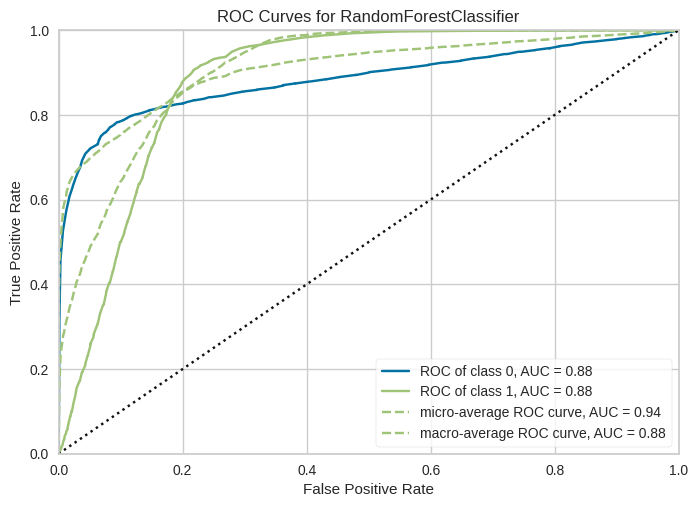

In [25]:
plot_model(rf)

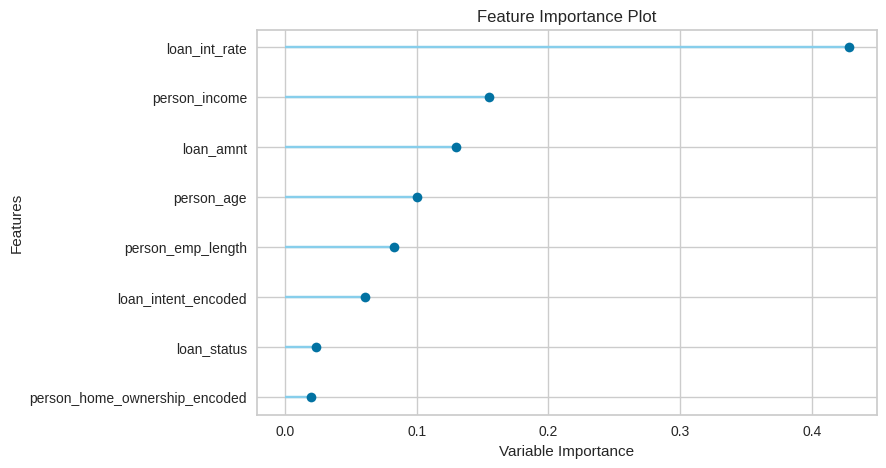

In [26]:
plot_model(rf, plot = 'feature')

In [27]:
pred_holdouts = predict_model(rf)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8267,0.8839,0.4061,0.5125,0.4531,0.3518,0.3552


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_encoded,loan_intent_encoded,cb_person_default_on_file,prediction_label,prediction_score
20625,32.0,70000,2.0,9850,7.750000,0,0.14,9,3,4,0,0,1.0000
23861,31.0,113000,1.0,9600,14.910000,1,0.08,7,3,2,1,1,0.7100
27438,29.0,108800,1.0,18500,17.799999,1,0.14,10,0,3,0,0,0.6083
14906,22.0,48000,5.0,15000,11.890000,1,0.31,4,3,3,0,0,0.9700
28333,28.0,53000,0.0,7000,9.880000,0,0.13,6,3,4,0,0,1.0000


In [28]:
save_model(rf,'/home/sihle/Kig_dataset/archive_creditScoring (1)')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['person_age', 'person_income',
                                              'person_emp_length', 'loan_amnt',
                                              'loan_int_rate', 'loan_status',
                                              'loan_percent_income',
                                              'cb_person_cred_hist_length',
                                              'person_home_ownership_encoded',
                                              'loan_intent_encoded'],
                                     transformer=SimpleImputer(add_indicator=False,...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                          